In [1]:
### import pandas as pd
import numpy as np

import pickle
import joblib
import os
import datetime
import time

#from ipynb.fs.full. processing_tools import *
from ipynb.fs.full. plotting_tools import *
from ipynb.fs.full. keras_tools import *

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('All packages sucessfully imported!')

### Params for plotting and figure matching
import matplotlib as mpl
#from matplotlib.ticker import FuncFormatte
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.dpi'] = 100
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

### Setting up functions
cwd = Path.cwd()

2.10.1
Num GPUs Available:  1
All packages sucessfully imported!


In [2]:
#Select Caases from where cross validation is performed 
cases = [#'DUCT_1100',
         #'DUCT_1150',
         #'DUCT_1250',
         #'DUCT_1300',
         #'DUCT_1350',
         #'DUCT_1400',
         #'DUCT_1500',
         #'DUCT_1600',
         #'DUCT_1800',
         #'DUCT_2000',
         #'DUCT_2205',
         #'DUCT_2400',
         #'DUCT_2600',
         #'DUCT_2900',
         #'DUCT_3200',
         #'DUCT_3500',
         'PHLL_case_0p5',
         'PHLL_case_0p8',
         'PHLL_case_1p0',
         'PHLL_case_1p2',
         'PHLL_case_1p5',
         # 'BUMP_h20',
         # 'BUMP_h26',
         # 'BUMP_h31',
         # 'BUMP_h38',
         # 'BUMP_h42',
         # 'CNDV_12600',
         # 'CNDV_20580',
         # 'CBFS_13700'
         ]
#Select test case
#test_case = ['PHLL_case_1p2',
             #'BUMP_h38',
             #'CNDV_20580',
             #'CBFS_13700'
 #           ]

# Select RANS model
dataset = 'komegasst' 
#Select Features
features = ['I1',
            'I2',
            'q'
           ]

                  
features_filter = ['I1_1', 'I1_2', 'I1_3', 'I1_4', 'I1_5', 'I1_6', 'I1_8', 'I1_9', 'I1_15', 'I1_17', 'I1_19', 'I2_3', 'I2_4', 'q_1', 'q_2']
zero_features = ['I1_7', 'I1_10', 'I1_11', 'I1_12', 'I1_13', 'I1_14', 'I1_16', 'I1_18', 'I1_20', 'I2_8', 'I2_9',
                 'I2_10', 'I2_11', 'I2_12', 'I2_13', 'I2_14', 'I2_15', 'I2_16', 'I2_17', 'I2_18', 'I2_19', 'I2_20']

print(f'>{len(zero_features)} are zero in 2D')

feat_list = []
for f in features:
    if f[0] == 'q':
        for i in range(1, 5):
            feat_list.append(f'{f}_{i}')
    else:
        for i in range (1, 21):
            feat_list.append(f'{f}_{i}')

if len(features_filter) > 0:
    feat_list = features_filter
            
feat_list = [f for f in feat_list if f not in zero_features]

    
print(f'>{len(feat_list)} features will be used')
print(feat_list)

    
# NL part
#Select Labels
labels_NL = 'a_NL'
labels = 'a_NL'
features_nut = 'eV'
#Select Tensors to use
features_tensors = 'Tensors' 
features_tensors_visc = ['Shat']

parent_directory = 'D:\\OneDrive - Universidade de Lisboa\\Turbulence Modelling Database\\' + dataset

#basis_name = '4_basis_S_R_K_P' ### This file should be made redundant and everything should be moved to Turb_V_name, llke a working fields directory

Turb_V_name = 'a_3_1_2_NL_S_DNS_eV'
#'a_4_1_2_NL_Wu_47'
# 'Pope_a'

dataset = parent_directory + '\\' + Turb_V_name + '\\'+ dataset

#current_file = 'JLK9.0
#current_file = 'ev_TBNN_JLK11'
current_file = 'eVNN_f2_OeV'

### Change to False to load models instead
construct_eVNN = True


### controll wheter you want to remove outliers or not
#both shoudl be set to true or false so that dimensions match when adding visc and linear terms
remove_outliers_id = False

remove_outliers_inference = False

cross_val = False

folders = ['imgs', 'models', 'scalers']

for folder in folders:
    if not os.path.exists(folder):
        # If it doesn't exist, create it
        os.makedirs(folder)

>22 are zero in 2D
>15 features will be used
['I1_1', 'I1_2', 'I1_3', 'I1_4', 'I1_5', 'I1_6', 'I1_8', 'I1_9', 'I1_15', 'I1_17', 'I1_19', 'I2_3', 'I2_4', 'q_1', 'q_2']


In [3]:
def build_mixer_cases_scaled(case_dict, coord, cases, train_cases,index=0):
    
    scaler = MinMaxScaler()

    inv_features = Stack_Cases(case_dict, None, index, train_cases)
    inv_features = scaler.fit_transform(inv_features)
    
    mixer_dict = {case: build_mixer_case(case_dict, coord, case, scaler, index=index)  for case in cases}
    
    return mixer_dict

def build_mixer_case(case_dict, coord, case, scaler, index=0):
    print(f'> {case}')
    c = np.array([[[0 for iii in range(3)] for ii in range(case_dict[case][index].shape[1])] for i in range(case_dict[case][index].shape[0])], dtype= np.float32)
    for i in range(case_dict[case][index].shape[0]):
        c[i,:,0] = scaler.transform(case_dict[case][index][i].reshape(1,-1))[0]
        c[i,:,1:] = np.tile(coord[case][i], (case_dict[case][index].shape[1],1))
    return c

        
def place_mixer_on_case_dict(case_dict_, mixer_dict, cases):
    case_dict = copy.deepcopy(case_dict_)
    for case in cases:
        case_dict[case][0] = mixer_dict[case]
    return case_dict

In [4]:
### load features on a per case basis, then stack them all together for training 
# case_dict will be [x, basis, Shat, y, Cx, Cy]

test_cases = ['PHLL_case_1p2']
val_cases = ['PHLL_case_0p8']

case_dict = {}

case_dict = {case: load_case(case, dataset, features, features_tensors, features_tensors_visc, labels_NL, labels, features_nut, feat_list) for case in cases}

for case in cases:    
    case_dict[case][0] = transform_data(case_dict[case][0],  feat_list)
    case_dict[case][5] = np.log(np.abs(case_dict[case][5])+1)
    print(f'> {case} successfully loaded\n - x: {case_dict[case][0].shape}\n - basis: {case_dict[case][1].shape}\n - Shat: {case_dict[case][2].shape}\n - y_NL: {case_dict[case][3].shape}\n - y: {case_dict[case][4].shape}\n - eV: {case_dict[case][5].shape}\n')


train_cases = [case for case in cases if case not in val_cases+test_cases]

_train = Stack_Cases(case_dict, None, 0, train_cases)
_eV_labels = Stack_Cases(case_dict, None, 5, train_cases)

scaler = build_scaler_labels(_train, [])[1]
#eV_labels, eV_scaler = build_scaler_eV(_eV_labels, [])
MinMax_eV = build_scaler_eV(_eV_labels, [])[1]

properties = {'PHLL': {'H': 5.142, 'A':3.858},
               'BUMP': {'C': 0.5*0.305},
               'CNDV': {'12600': 12.6, '20580': 25.3 }
                }

coords = {}  

for case in cases:
    if case[:4] == 'PHLL':
        coords[case] = np.hstack((case_dict[case][-2].reshape(-1,1)/((properties[case[:4]]['A']*float(f'{case[-3]}.{case[-1]}')+properties[case[:4]]['H'])), case_dict[case][-1].reshape(-1,1)))
    if case[:4] == 'BUMP':
        coords[case] = np.hstack((case_dict[case][-2].reshape(-1,1)/properties[case[:4]]['C'], case_dict[case][-1].reshape(-1,1)/float(f'0.0{case[-2:]}')))
    if case[:4] == 'CNDV':
        coords[case] = np.hstack((case_dict[case][-2].reshape(-1,1), case_dict[case][-1].reshape(-1,1)))


>I1_1 data strictly positive or negative: applying log transformation
>I1_2 not transformed as it is not skewed enough
>I1_3 data strictly positive or negative: applying log transformation
>I1_4 data strictly positive or negative: applying log transformation
>I1_5 not transformed as it is not skewed enough
>I1_6 data strictly positive or negative: applying log transformation
>I1_8 not transformed as it is not skewed enough
>I1_9 data strictly positive or negative: applying log transformation
>I1_15 not transformed as it is not skewed enough
>I1_17 not transformed as it is not skewed enough
>I1_19 not transformed as it is not skewed enough
>I2_3 data strictly positive or negative: applying log transformation
>I2_4 data strictly positive or negative: applying log transformation
> PHLL_case_0p5 successfully loaded
 - x: (14751, 15)
 - basis: (14751, 20, 3, 3)
 - Shat: (14751, 3)
 - y_NL: (14751, 4)
 - y: (14751, 4)
 - eV: (14751, 1)

>I1_1 data strictly positive or negative: applying log 

## eVNN plots

In [5]:
def eV_plot(ev, cX, cY, case):
    fig = plt.figure(figsize=(10, 5))
    plt.subplots_adjust(hspace=0.5)
    #plt.suptitle('OeVTBNN', fontsize=20, y=1.)
    #plt.subplots_adjust(hspace=3)
         
    x, y = extract_wall_surf(cX, cY, case)    
        
    # create a common colorbar for each pair of subplots
    cmap = matplotlib.colormaps['coolwarm']
    
    ax = plt.subplot(1, 1, 1)
            
    # filter df and plot ticker on the new subplot axis
    
    #ax.set_title('eV', fontsize=20)
        
    #ax.set_ylabel('eVTBNN_3b_ff', fontsize=20, rotation=90, labelpad=8)
    if max(ev) > .1:   
        vmax =  float(max(ev))
        vmin =  float(min(ev)) 
    else:
        vmax =  float(0.005)
        vmin =  float(0) 

    norm = Normalize(vmin=vmin, vmax=vmax)
    levels = create_levels(vmin, vmax)

    cont = ax.tricontourf(cX, cY, ev, norm = norm, cmap = cmap, levels = levels,  extend = 'both')
    ax.fill_between(x, y, facecolor = 'lightsteelblue', edgecolor = 'black', interpolate = True)

    ax.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.set_title(case, fontsize=20, y=1.)
    ax.set_aspect(1.3)

 # Add a colorbar to the plot

    cbar = plt.colorbar(cont, ax=ax, format='%0.5f', orientation='vertical', shrink=.8, pad=0.1, ticks = [vmin, vmax])
    cbar.ax.tick_params(labelsize=10)
    
    # print(ev.max())
    # print(ev.min())
    # print(ev.mean())
            
    fig.tight_layout()   
    
    plt.savefig(f'imgs\\{current_file}_eff_visc_{case}')


def get_plot_eV_hist(eV, case, current_file, set_):
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    sns.histplot(eV, ax = axes, bins = 300, stat = 'count', element = 'bars', kde = False, log_scale = [False, False])
    axes.set_title(case, fontsize=20)
    axes.tick_params(axis = 'both', labelsize = 16)
    axes.set_ylabel('Count', fontsize=16)
    fig.tight_layout()   
    plt.savefig(f'imgs\\{current_file}_eV_hist_{set_}')



In [6]:
def preprocess_eV(case_dict):
    _clean = copy.deepcopy(case_dict)

    for case in _clean.keys():
        print(case)
        print(np.median(_clean[case][5]))
        print(np.quantile(_clean[case][5],0.99))
        print('\n')

In [7]:
preprocess_eV(case_dict)

PHLL_case_0p5
0.00023633563127480042
0.002454989881804534


PHLL_case_0p8
0.00015916334891282304
0.002497904191906011


PHLL_case_1p0
0.00012006254353385992
0.0028850982287164594


PHLL_case_1p2
9.82283634478372e-05
0.0030331601260356177


PHLL_case_1p5
6.365613939278002e-05
0.0015665184621473337




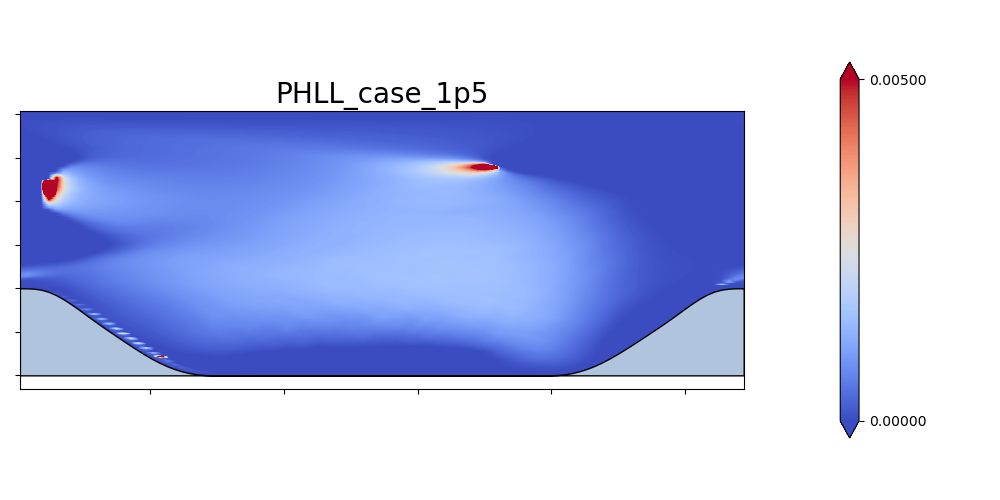

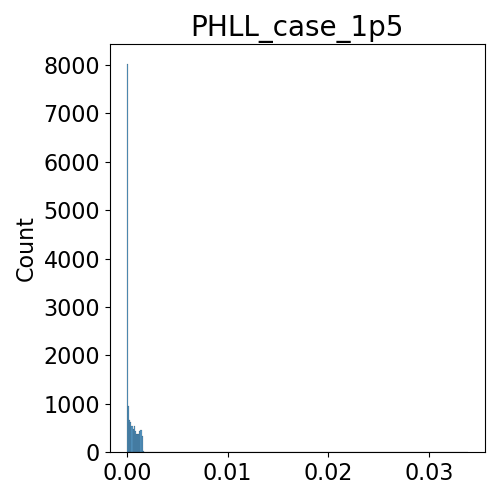

In [8]:


eV_plot(case_dict[case][5][:,0], case_dict[case][-2], case_dict[case][-1], case)
get_plot_eV_hist(case_dict[case][5][:,0], case, current_file, '')

### Pre Scaling

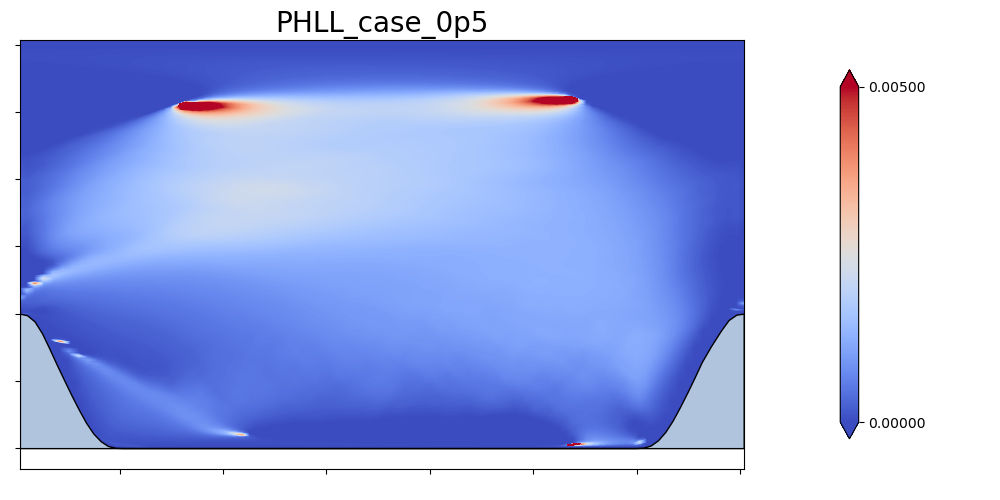

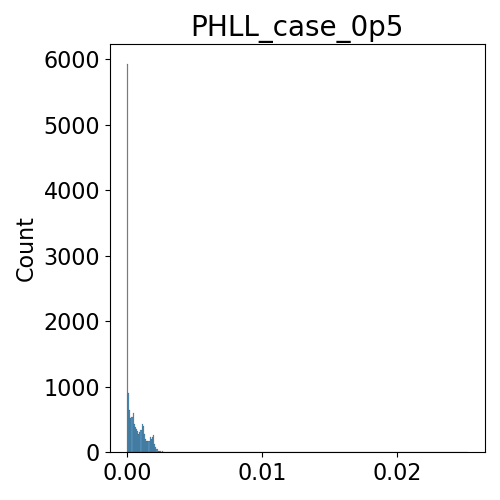

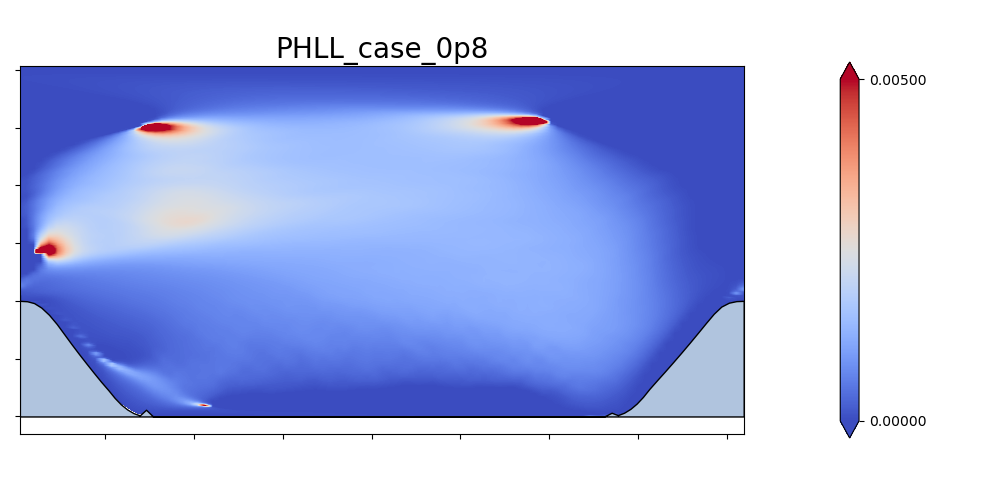

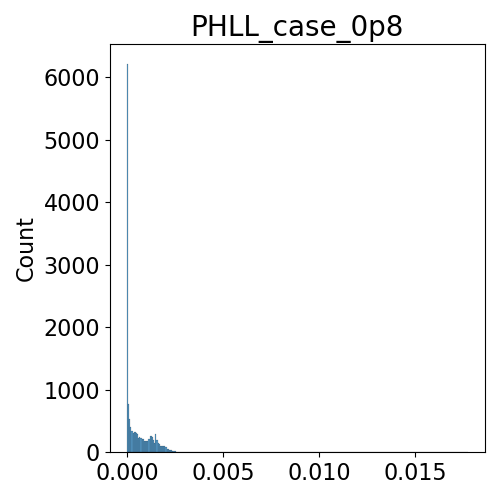

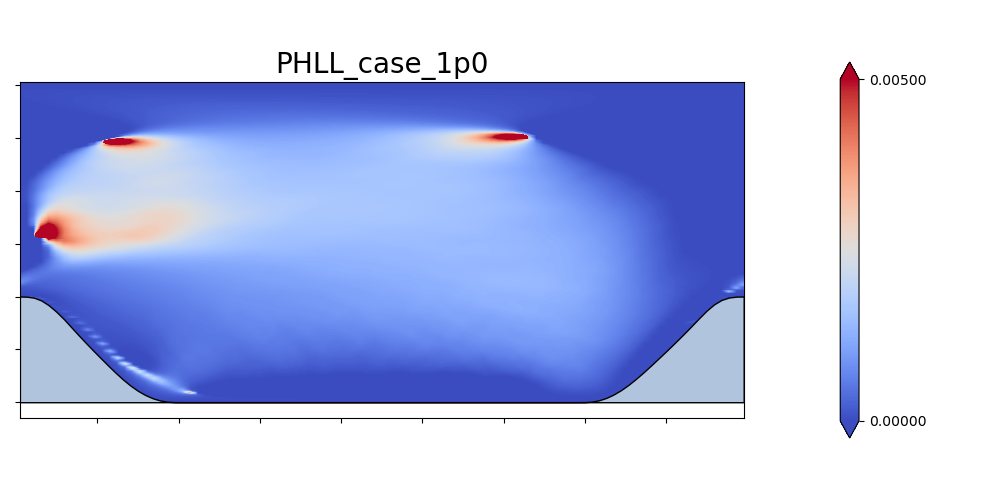

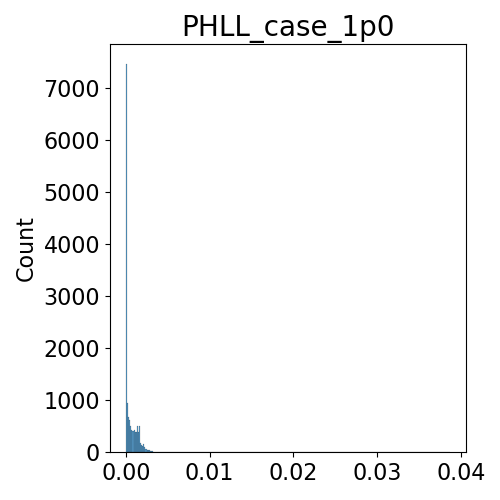

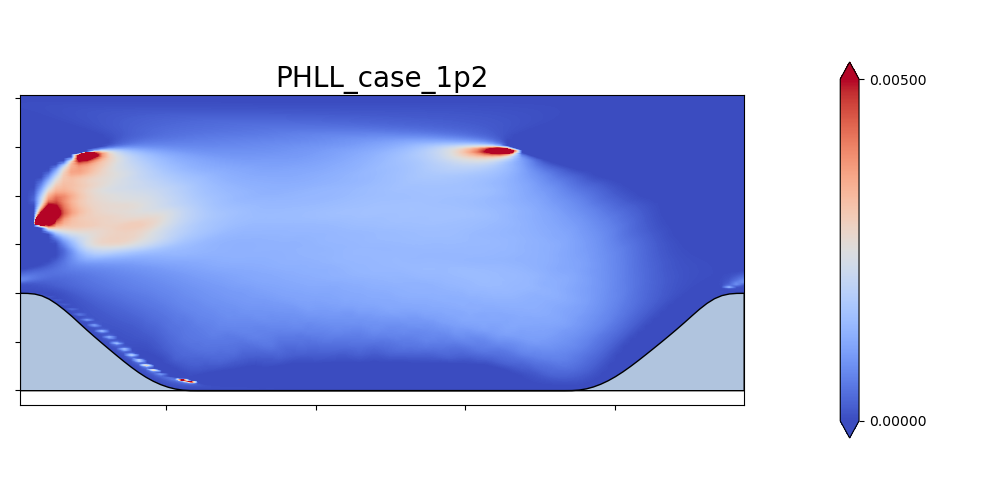

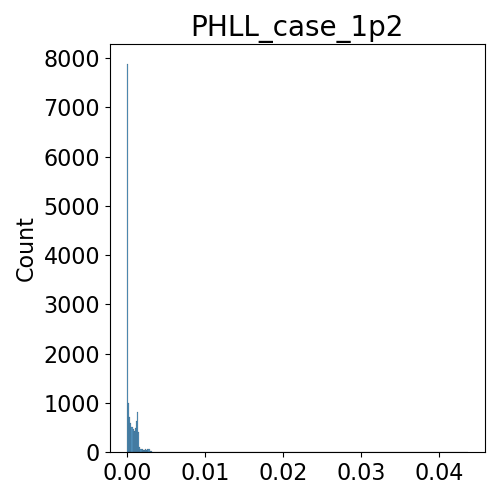

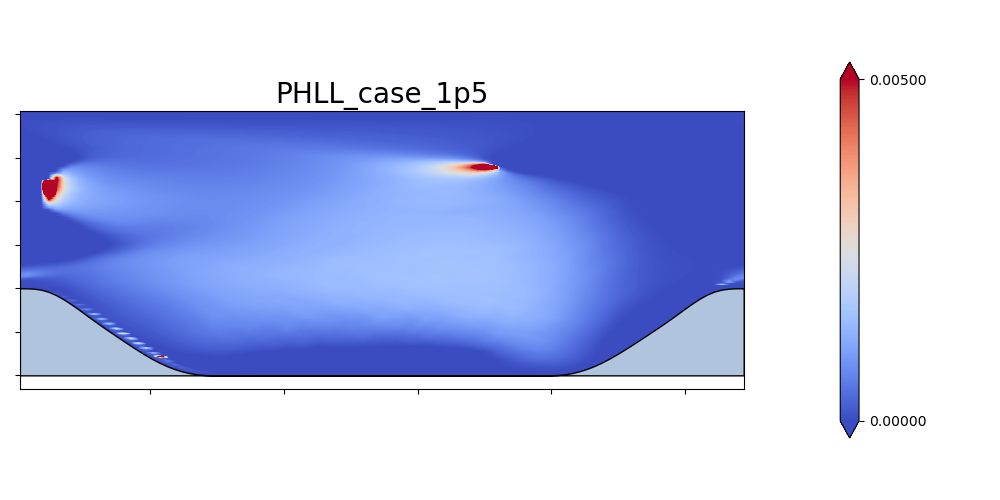

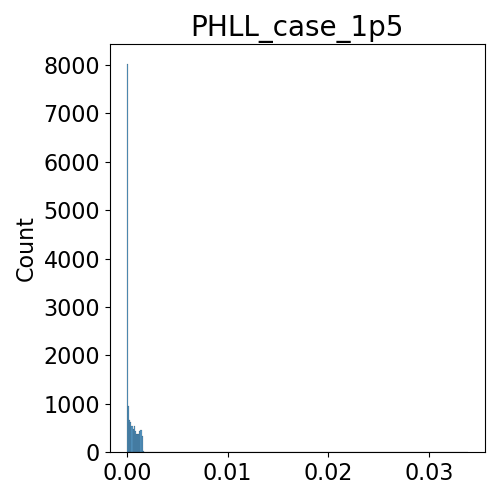

In [9]:
for case in cases:
    eV_plot(case_dict[case][5][:,0], case_dict[case][-2], case_dict[case][-1], case)
    get_plot_eV_hist(case_dict[case][5][:,0], case, current_file, '')

### Scaled

In [10]:
for case in cases:
    case_dict[case][0] = scaler.transform(case_dict[case][0])
    case_dict[case][5] = MinMax_eV.transform(case_dict[case][5])

mixer_dict = build_mixer_cases_scaled(case_dict, coords, cases, train_cases)

case_dict = place_mixer_on_case_dict(case_dict, mixer_dict, cases)

> PHLL_case_0p5
> PHLL_case_0p8
> PHLL_case_1p0
> PHLL_case_1p2
> PHLL_case_1p5


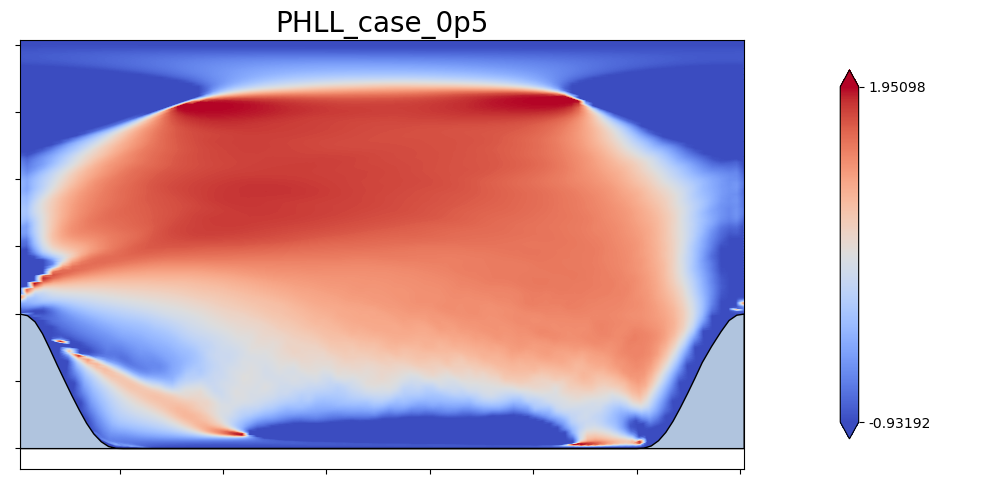

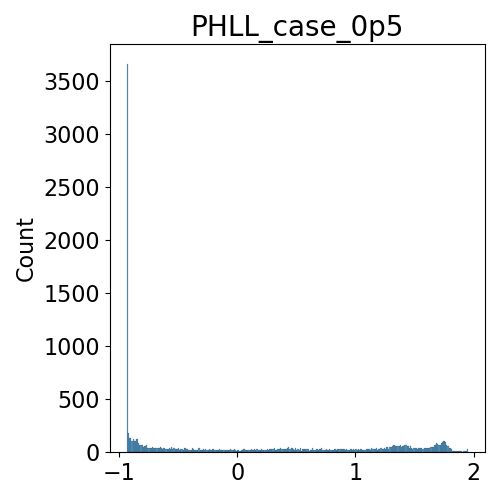

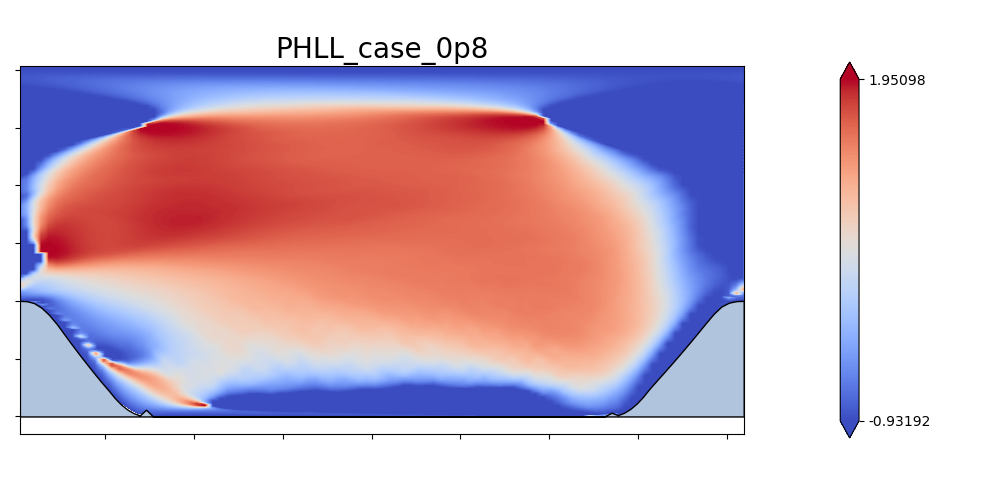

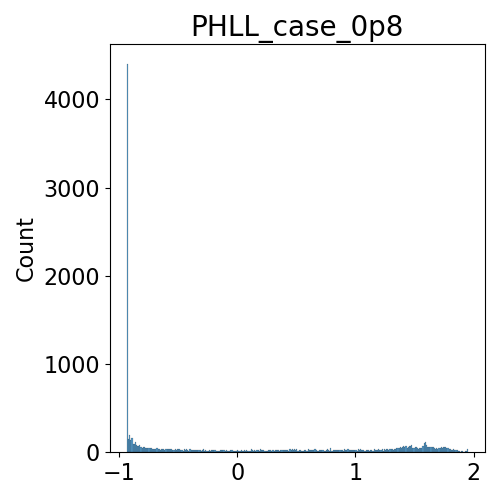

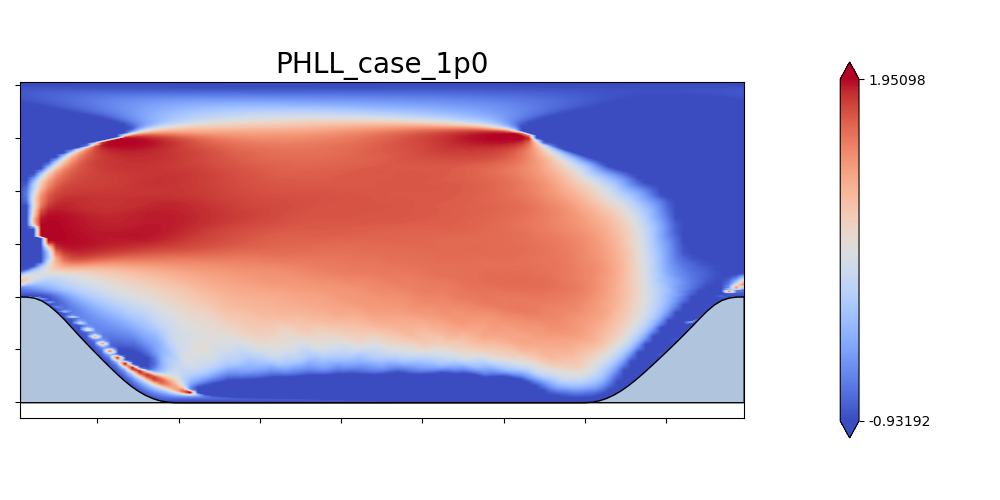

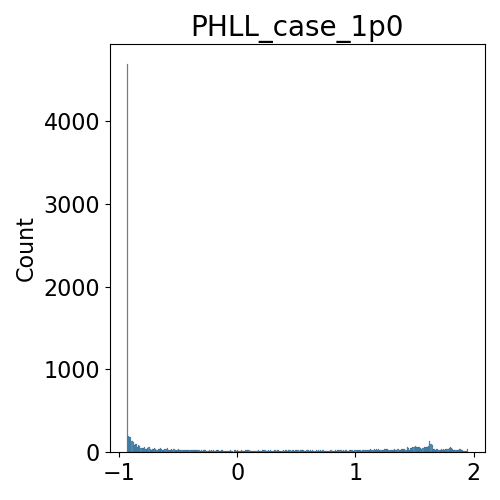

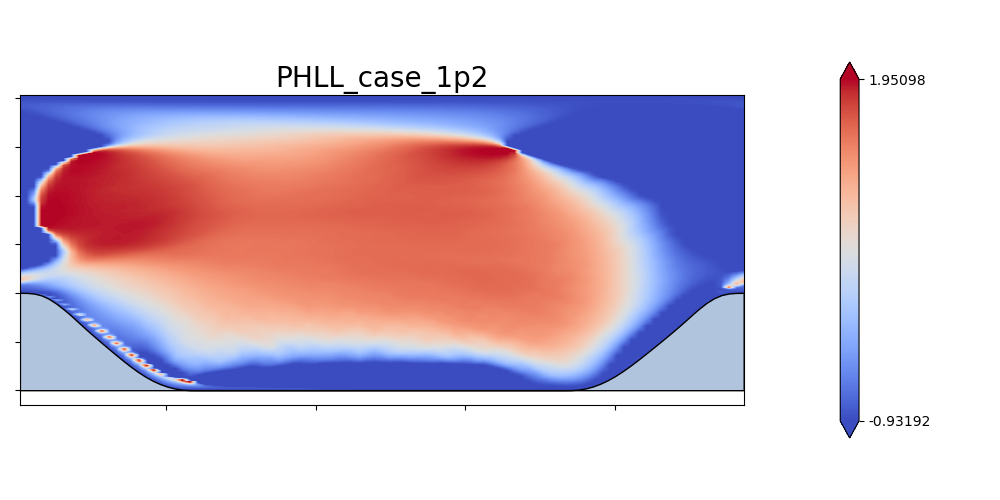

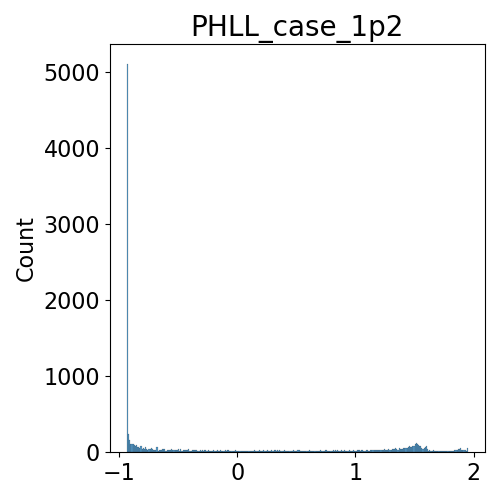

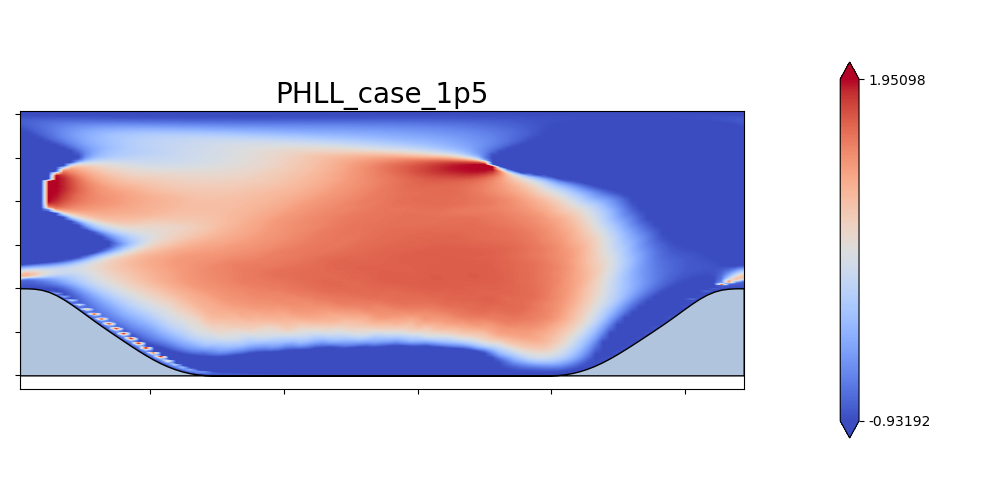

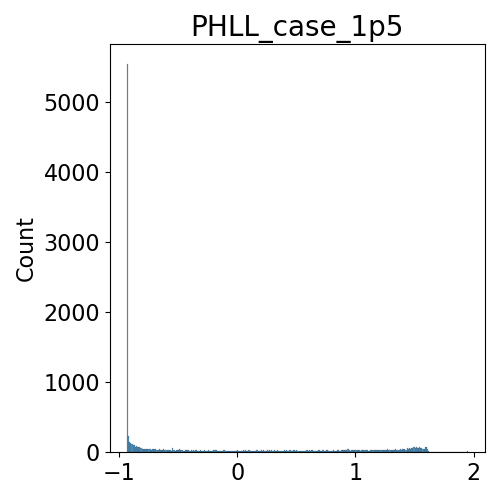

In [11]:
for case in cases:
    eV_plot(case_dict[case][5][:,0], case_dict[case][-2], case_dict[case][-1], case)
    get_plot_eV_hist(case_dict[case][5][:,0], case, current_file, '')

## Train 

In [12]:
train = [Stack_Cases(case_dict, None, index, train_cases) for index in range(6)]
val =  [Stack_Cases(case_dict, None, index, val_cases) for index in range(6)]

train = [shuffle(train[i], random_state = 0) for i in range(6) ]
val = [shuffle(val[i], random_state = 0) for i in range(6) ]

In [13]:
import pandas as pd 
import xgboost as xgb

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience = 15,
        verbose=0,
        mode="auto",
        min_delta=0.00004,
        cooldown=30,
        min_lr=1e-7,
    )

early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.00001,
        patience = 40,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

log_dir = f"logs_{current_file}/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



def train_eVNN(_train, _val, model, construct_eVNN, epochs, batch_size, current_file, cwd):
    history_lr = []
    if construct_eVNN:
        history = model.fit(_train[0], _train[5], 
                                batch_size = batch_size,
                                epochs = epochs, 
                                validation_data = (_val[0], _val[5]), 
                                verbose = 1, 
                                callbacks = [early_stop, 
                                            reduce_lr,
                                            tensorboard_callback
                                            #WandbMetricsLogger(log_freq=5),
                                            #WandbModelCheckpoint("models")
                                            ]
                            )
            
        history_lr.append(round(model.optimizer.lr.numpy(), 5))
        # Read as a dataframe 
        print('\n\n\n')
        metrics = pd.DataFrame(history.history)
        fig, axs = plt.subplots(1, 4, figsize=(40, 10))
        fig.suptitle(f'Training {current_file}', fontsize=40, y=1.0)
        plot_graphs1('loss', 'val_loss', 'Training and Validation Loss', metrics, i, ax=axs[0])
        plot_graphs1('mse', 'val_mse', 'Training and Validation MSE', metrics, i, ax=axs[1])
        plot_graphs1('mae', 'val_mae', 'Training and Validation MAE', metrics, i, ax=axs[2])
        plot_graphs1('lr', 'loss', 'Loss and LR', metrics, i, ax=axs[3])
        for j in range(4):
            axs[j].tick_params(axis = 'both', labelsize = 20)
        plt.tight_layout()
        plt.savefig(f'imgs\\{current_file}_Model_Metrics_eVNN')
        ## Savinf Scaler and the model, to allow testing later
        tf.keras.models.save_model(model, f'models\\saved_model_{current_file}_eVNN.h5')
    
    else:
        model = tf.keras.models.load_model(os.path.join(cwd, f'models\\saved_model_{current_file}_eVNN.h5'), custom_objects={'custom_tanh': custom_tanh})

    return model

Model: "eVNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 15, 3)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 15, 3)       90          ['input_layer[0][0]']            
 alization)                                                                                       
                                                                                                  
 tf.compat.v1.transpose (TFOpLa  (None, 3, 15)       0           ['layer_normalization[0][0]']    
 mbda)                                                                                            
                                                                                               

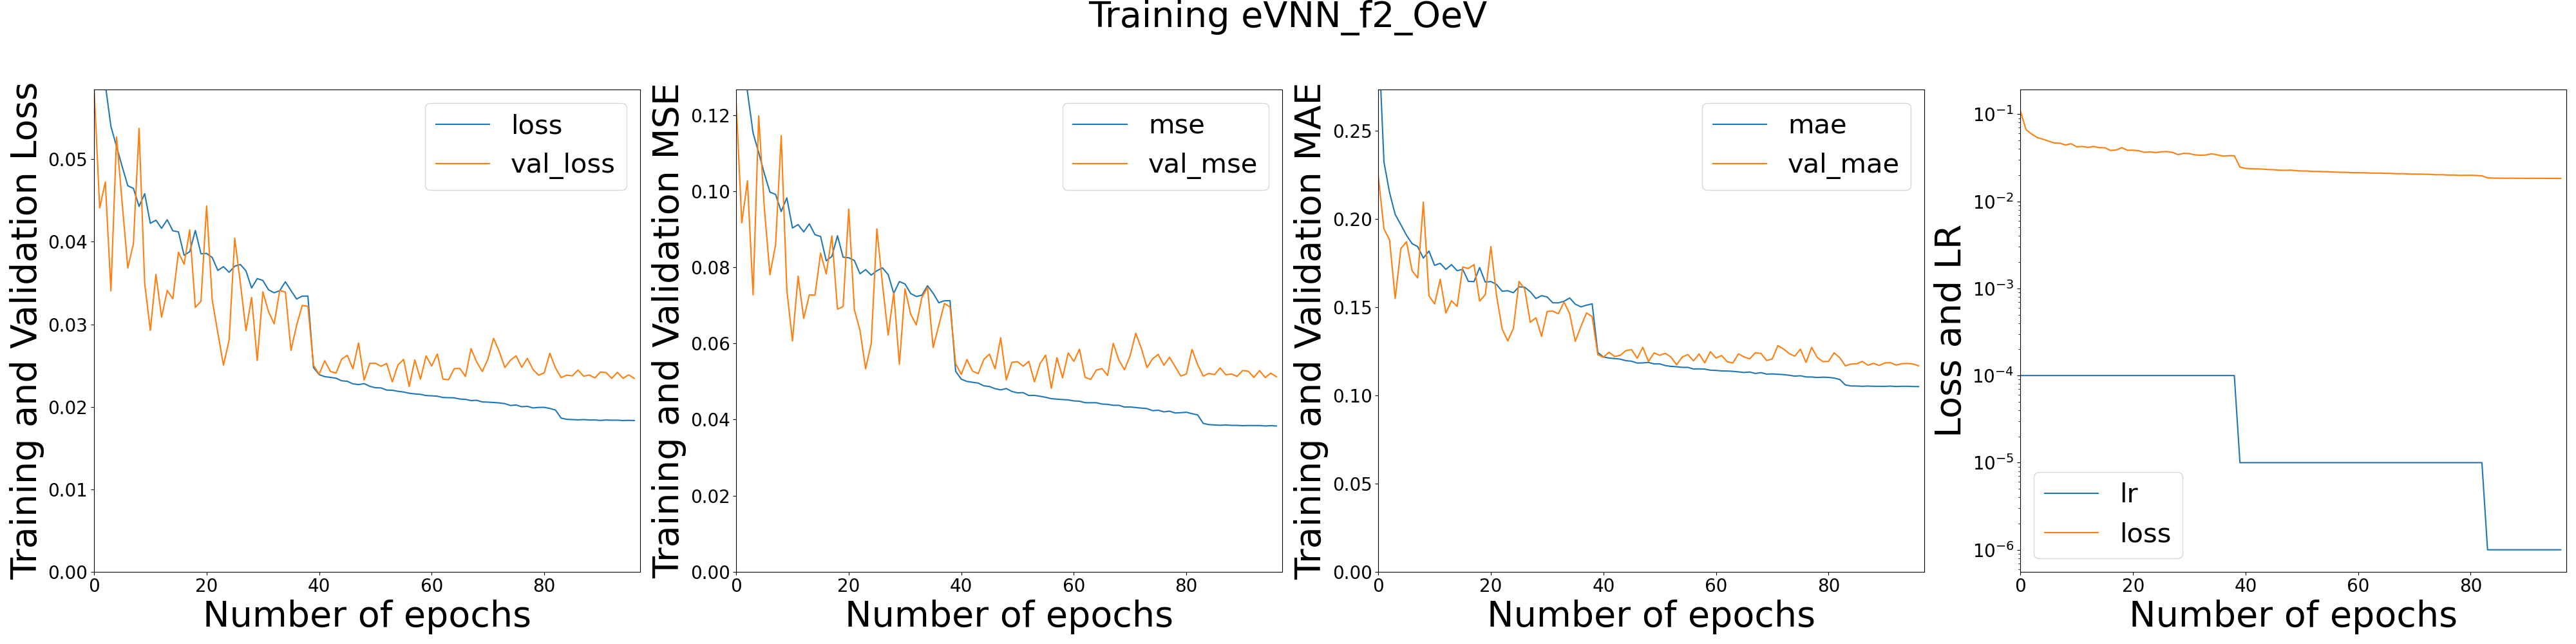

In [14]:
## Setting Batch Size and Epochs
batch_size =  128
epochs = 500

# Setting Learning rate
lr = 1e-4

# Setting Depth and Width of NNs
layers_eVNN = 2
units_eVNN = 150
n_dense_eVNN = 5

eVNN_model = build_eVNN(lr, layers_eVNN, units_eVNN, n_dense_eVNN, cwd, current_file)

eVNN_model = train_eVNN(train, val, eVNN_model, construct_eVNN, epochs, batch_size, current_file, cwd)

In [15]:
def pedict_parity_eVNN(eV_pred_dict, case_dict, eVNN, cases, MinMax_eV, labels_scaler_eV, current_file):
        
    for case in cases:

        _labels = np.abs(np.exp(MinMax_eV.inverse_transform(case_dict[case][5]))-1)[:,0] 
        eV_pred_dict[case] = np.abs(np.exp(MinMax_eV.inverse_transform(eVNN.predict([case_dict[case][0]])))-1)[:,0] 
                                                                       #np.array([max(_, 0) for _ in gaussian_filter1d(predict_XGB(eV_booster, case_dict[case][0], _labels, MinMax_eV), 0.5, order=0)])
        print(max(eV_pred_dict[case]))
        print(min(eV_pred_dict[case]))

        #print([i for i in np.isnan(eV_pred_dict[case]) if i])


        print(f'\n====== {case} eVMetrics ======')
        print(f'> mean absolute error = {mean_absolute_error( _labels, eV_pred_dict[case])}')
        print(f'> mean squared error = {mean_squared_error( _labels, eV_pred_dict[case])}')
        print(f'> r2 score = {r2_score( _labels, eV_pred_dict[case]):.3f}')
        print('\n\n\n')



        #
        # get_parity_plots(eV_pred_dict[case] ,_labels, case, current_file, '') 
        

        eV_plot(eV_pred_dict[case], case_dict[case][-2], case_dict[case][-1], case)
        eV_plot(_labels, case_dict[case][-2], case_dict[case][-1], case)
        get_plot_eV_hist(_labels, case, current_file, '')

        

            

461/461 [==============================] - 9s 17ms/step
0.0027139187
0.0

====== PHLL_case_0p8 eVMetrics ======
> mean absolute error = 0.00011407815625655754
> mean squared error = 1.6259288795499597e-07
> r2 score = 0.705






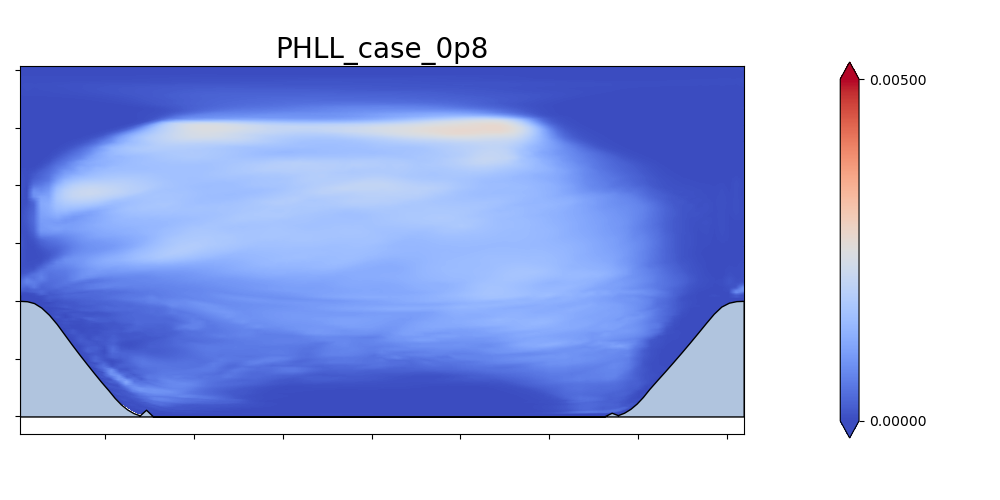

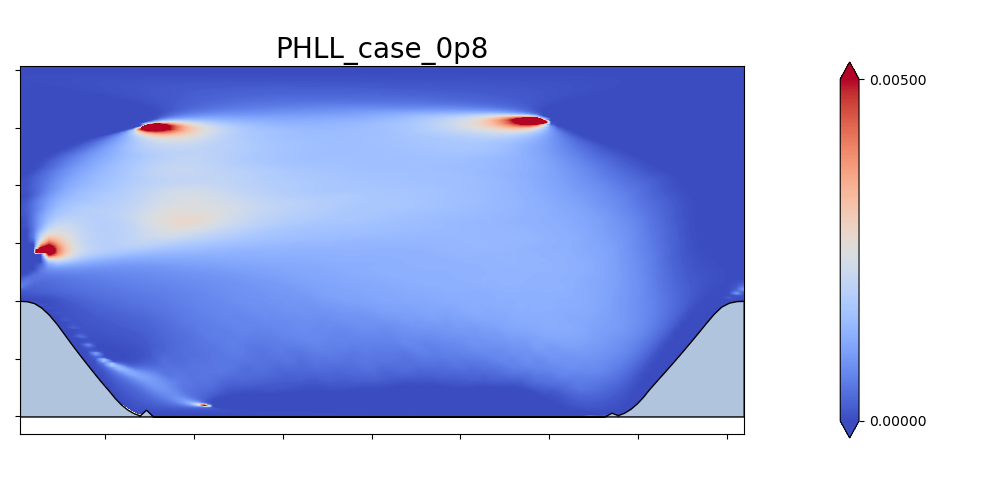

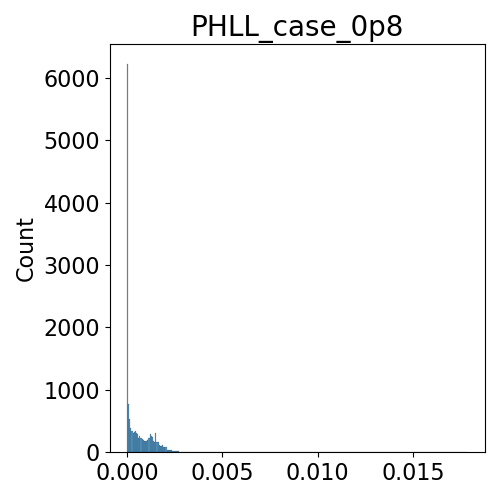

In [16]:
eV_pred_dict = {}
eV_scaler=[]
pedict_parity_eVNN(eV_pred_dict, case_dict, eVNN_model, val_cases, MinMax_eV,eV_scaler, current_file)

461/461 [==============================] - 8s 17ms/step
0.0020945072
0.0

====== PHLL_case_1p2 eVMetrics ======
> mean absolute error = 0.00011495326631862401
> mean squared error = 2.803772574800158e-07
> r2 score = 0.574






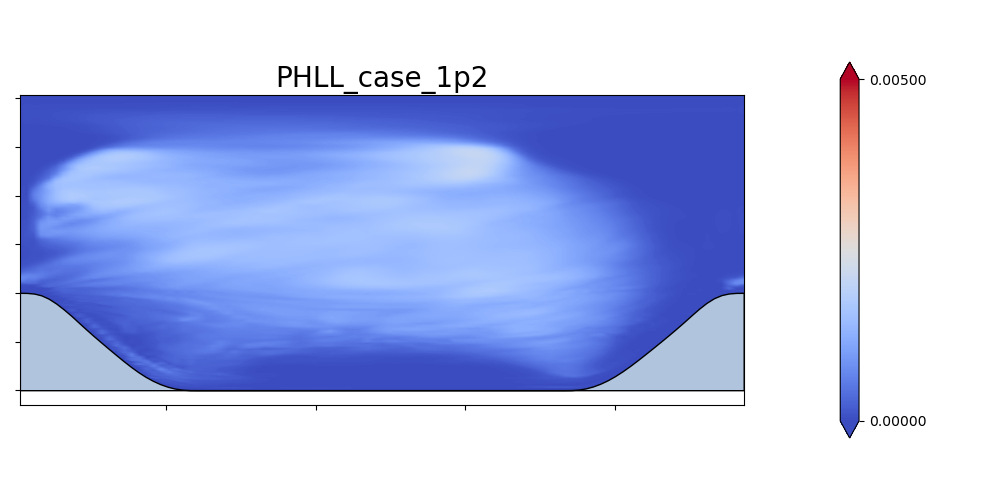

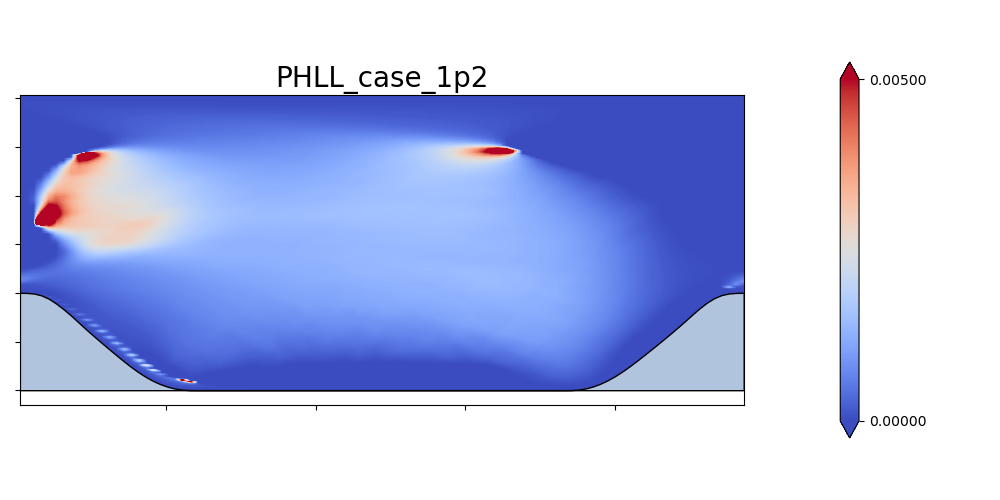

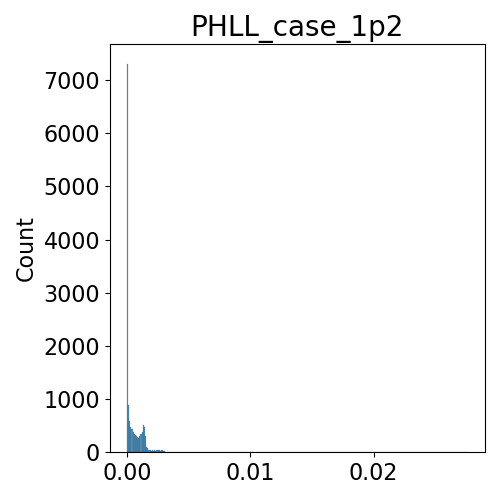

In [17]:
pedict_parity_eVNN(eV_pred_dict, case_dict, eVNN_model, test_cases, MinMax_eV, eV_scaler, current_file)

In [18]:
full_pred_dict = {case:{
                        'eV': eV_pred_dict[case]
                       } for case in test_cases}

with open(f'folds_dict//eV_f2.pkl', 'wb') as fp:
    pickle.dump(eV_pred_dict, fp)
    print('dictionary saved successfully to file')


dictionary saved successfully to file
